In [5]:
rm(list=ls())
libraries = c("dplyr","magrittr","tidyr","reshape2","ggplot2","ggpubr","hrbrthemes","extrafont","openxlsx","readxl","RColorBrewer","zoo",
              "readxl","writexl","gridExtra","MASS","readr","stats","boot","pracma","stringr","mixdist","corpcor","rstan","bayesplot")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE) }

theme_set(theme_bw())
setwd("../wane_ve_estimation_multivariant")

In [7]:
ncov_vax <- read_csv("data/vax_rollout_simulation.csv") 
ncov_vax%>%head(5);ncov_vax%>%tail(5)

Parsed with column specification:
cols(
  week = col_double(),
  vaccine = col_double(),
  cumulative = col_double()
)



week,vaccine,cumulative
<dbl>,<dbl>,<dbl>
1,14532,358776
2,14783,373559
3,17431,390990
4,31970,422960
5,97021,519981


week,vaccine,cumulative
<dbl>,<dbl>,<dbl>
69,12448,12586925
70,11167,12598092
71,13168,12611260
72,9513,12620773
73,13262,12634035


### Scenario 1

In [8]:
### ve basic function
basicfn <- function(p,k,t){
    fn <-  p*(1/(exp(k*(t-1)) + 1))
    return(fn)
}

ve_A <- function(t){
    fn <- basicfn(p=0.95*2,k=0.01,t) #0.002
    return(fn)
}
ve_B <- function(t){
    fn <- basicfn(p=0.90*2,k=0.02,t) #0.005
    return(fn)
}
ve_C <- function(t){
    fn <- basicfn(p=0.90*2,k=0.01,t) #0.012
    return(fn)
}
ve_D <- function(t){
    fn <- basicfn(p=0.80*2,k=0.03,t)
    return(fn)
}

[1] 0.8000000 0.7880009 0.7760072 0.7640243 0.7520575 0.7401122 0.7281938
 [8] 0.7163073 0.7044582 0.6926514 0.6808920 0.6691850 0.6575353 0.6459477
[15] 0.6344268 0.6229772 0.6116034 0.6003096 0.5891001 0.5779789 0.5669499
[22] 0.5560169 0.5451834 0.5344529 0.5238288 0.5133141 0.5029118 0.4926248
[29] 0.4824557 0.4724069 0.4624808 0.4526795 0.4430051 0.4334593 0.4240438
[36] 0.4147602 0.4056096 0.3965934 0.3877126 0.3789680 0.3703603 0.3618903
[43] 0.3535582 0.3453645 0.3373093 0.3293926 0.3216144 0.3139745 0.3064726
[50] 0.2991082 0.2918808 0.2847899 0.2778346 0.2710142 0.2643278 0.2577743
[57] 0.2513528 0.2450619 0.2389007 0.2328677 0.2269617 0.2211812 0.2155249
[64] 0.2099912 0.2045785 0.1992854 0.1941101 0.1890512 0.1841068 0.1792753
[71] 0.1745549 0.1699440 0.1654407

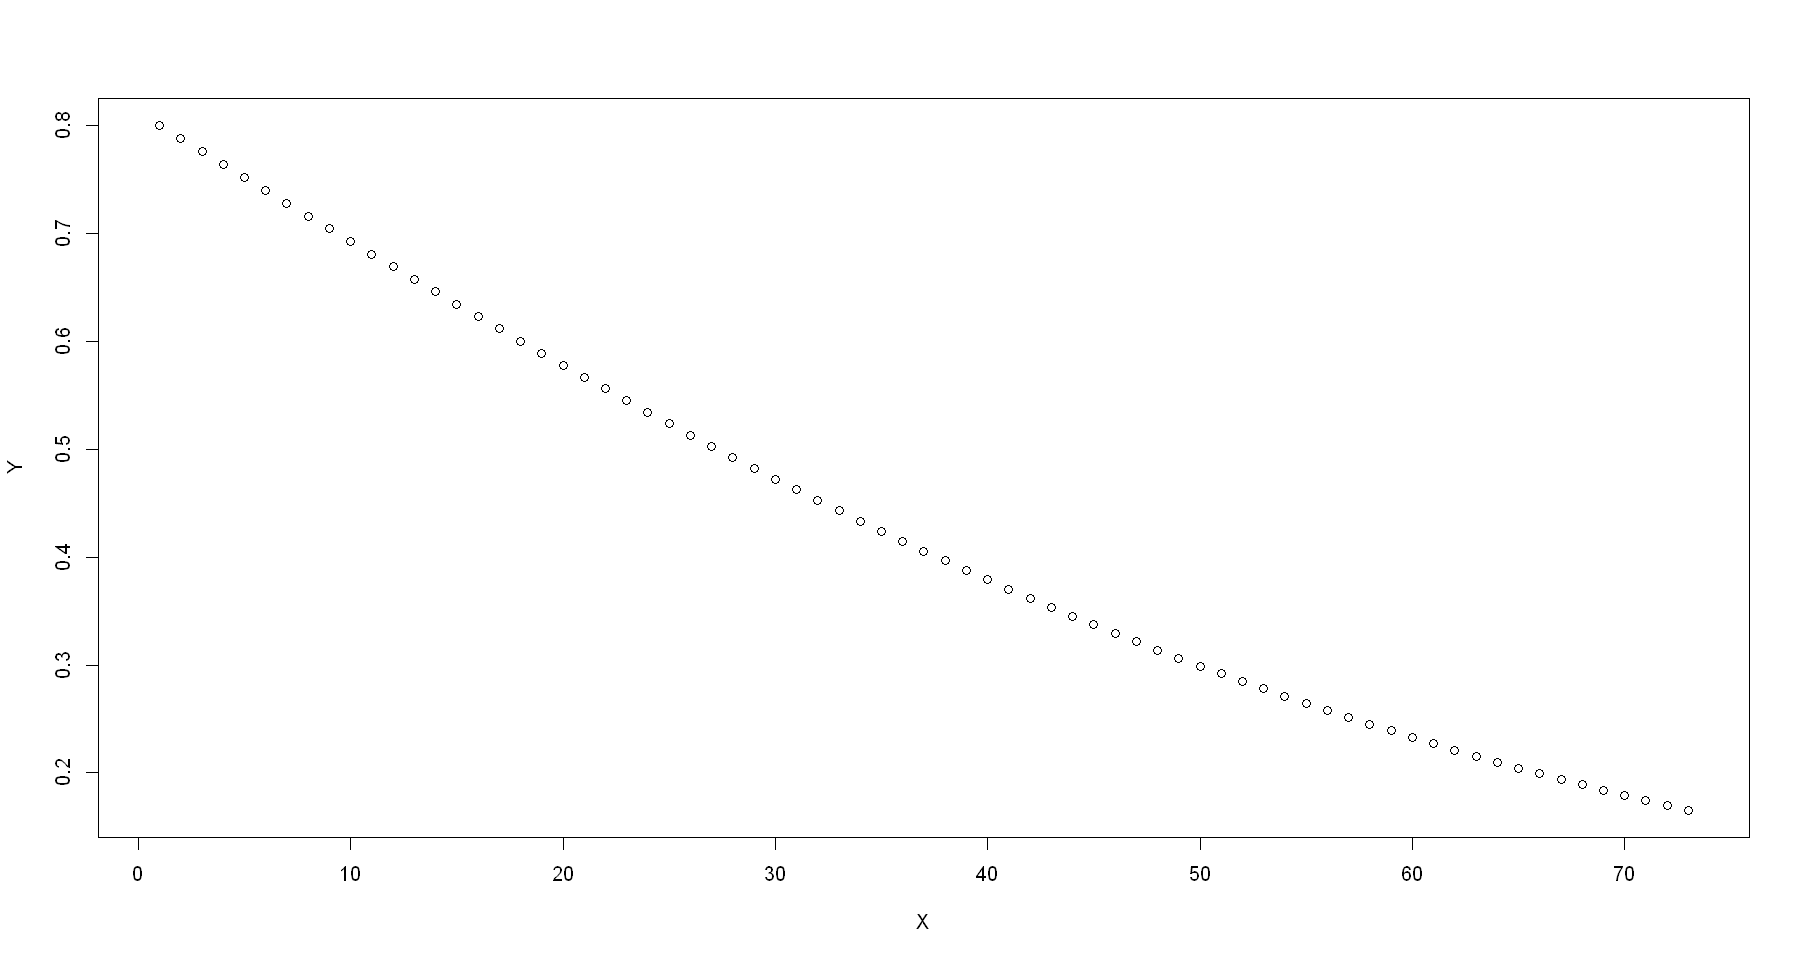

In [194]:
### check ve function
options(repr.plot.width=15,repr.plot.height=8)
X <- seq(1,73,1)
Y <- rep(0,73)
for(i in 1:73){Y[i] <- ve_D(i)}
Y
plot(X,Y)

In [268]:
source("src/R/Simulation.R") # load functions

In [10]:
### dataframe of case by vaccination status and variant
df_unvac <- rbind(iit_A,iit_B,iit_C,iit_D) %>% t()
df_vac <- rbind(jjt_A,jjt_B,jjt_C,jjt_D) %>% t()
label <- c(rep("A",T),rep("B",T),rep("C",T),rep("D",T)) %>% as.data.frame()
week <- seq(1,T,1) %>% rep(4) %>% as.data.frame()
case_df_type <- cbind(week,df_unvac,df_vac,label)
colnames(case_df_type) <- c("Week","Unvaccinated_A","Unvaccinated_B","Unvaccinated_C","Unvaccinated_D","Vaccinated_A","Vaccinated_B","Vaccinated_C","Vaccinated_D","Variant")
case_df_type
### dataframe of case by variant for the analysis
A_prop <- c(1,(iit_A[1:(T-1)]+jjt_A[1:(T-1)])/(iit[1:(T-1)]+jjt[1:(T-1)])) %>% as.data.frame()
B_prop <- c(0,(iit_B[1:(T-1)]+jjt_B[1:(T-1)])/(iit[1:(T-1)]+jjt[1:(T-1)])) %>% as.data.frame()
C_prop <- c(0,(iit_C[1:(T-1)]+jjt_C[1:(T-1)])/(iit[1:(T-1)]+jjt[1:(T-1)])) %>% as.data.frame()
D_prop <- c(0,(iit_D[1:(T-1)]+jjt_D[1:(T-1)])/(iit[1:(T-1)]+jjt[1:(T-1)])) %>% as.data.frame()
df_voc <- rbind(A_prop, B_prop, C_prop, D_prop) 
label <- c(rep("Variant A",T),rep("Variant B",T),rep("Variant C",T),rep("Variant D",T)) %>% as.data.frame()
week <- seq(1,T,1) %>% rep(4) %>% as.data.frame()
case_voc <- cbind(week,df_voc,label)
colnames(case_voc) <- c("Week","Proportion","Variant")

A <- case_voc %>% filter(Variant == "Variant A")
B <- case_voc %>% filter(Variant == "Variant B")
C <- case_voc %>% filter(Variant == "Variant C")
D <- case_voc %>% filter(Variant == "Variant D")



### dataframe of case by vaccination status for the analysis
df_unvac_non <- (iit[1:T]) %>% as.data.frame()
df_vac_non <- (jjt[1:T]) %>% as.data.frame()
week1 <- seq(1,T,1)
case_df <- cbind(week1,df_unvac_non,df_vac_non)
colnames(case_df) <- c("Week","Unvaccinated","Vaccinated")

### dataframe of case by vaccinqation status for plot
week2 <- seq(1,T,1) %>% rep(2)
Type <- c(rep("Unvaccinated",T),rep("Vaccinated",T))
case_df_plot <- cbind(week2,rbind(df_unvac_non,df_vac_non),Type)
colnames(case_df_plot) <- c("Week","Case","Type")

Week,Unvaccinated_A,Unvaccinated_B,Unvaccinated_C,Unvaccinated_D,Vaccinated_A,Vaccinated_B,Vaccinated_C,Vaccinated_D,Variant
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,5300,0,0,0,30,0,0,0,A
2,5200,0,0,0,50,0,0,0,A
3,2157,0,0,0,52,0,0,0,A
4,1416,0,0,0,44,0,0,0,A
5,1100,0,0,0,47,0,0,0,A
6,697,0,0,0,40,0,0,0,A
7,536,0,0,0,38,0,0,0,A
8,418,0,0,0,42,0,0,0,A
9,332,0,0,0,63,0,0,0,A


### simulation code

### stan code

In [30]:
source("src/stan/Model_Simulation_param.stan") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

In [12]:
It <- case_df_plot %>% filter(Type=="Unvaccinated") 
Jt <- case_df_plot %>% filter(Type=="Vaccinated") 

In [32]:
## modify data into a form suitable for Stan
delay=0
l=2 # adjustment for left censoring
m=0 # control the end of observation period 
T = nrow(A)-l-m # number of days
N = 15000000
num_data = T+l+delay
it = It$Case
jt = Jt$Case
vA = A$Proportion[1:(T+l+delay)]
vB = B$Proportion[1:(T+l+delay)]
vC = C$Proportion[1:(T+l+delay)]
vD = D$Proportion[1:(T+l+delay)]
vaccine= ncov_vax$vaccine[1:(T+l+delay)]/N
odds = ncov_vax$cumulative[1:(T+l+delay)]/(N-ncov_vax$cumulative[1:(T+l+delay)])
si = plnorm(seq(7, (T+l)*7, by = 7), log(4.699), log(2.936))-plnorm(seq(0, (T+l)*7-7, by = 7), log(4.699), log(2.936)) #serial interval (Nishiura et al. 2020)

data = list(T=T, N=N, it=it, jt=jt, Gamma=vaccine, SI=si, odds=odds, vA=vA, vB=vB, vC=vC, vD=vD, delay=delay, l=l, num_data=num_data)
# specify parameters to monitor
parameters = c("ve_o","ve_a","ve_d","ve_om","zeta","eta","Rit","Rjt","k","p","ii","jj")
# eps: overall effect over time, ve: direct effect over time


nuts_fit1 = stan(model_code=Model,data=data,pars=parameters,iter=2500,thin=1,warmup=500,chain=2)


SAMPLING FOR MODEL '8bbd3f42bb260e8d9f54e0c78019cb87' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2500 [  0%]  (Warmup)
Chain 1: Iteration:  250 / 2500 [ 10%]  (Warmup)
Chain 1: Iteration:  500 / 2500 [ 20%]  (Warmup)
Chain 1: Iteration:  501 / 2500 [ 20%]  (Sampling)
Chain 1: Iteration:  750 / 2500 [ 30%]  (Sampling)
Chain 1: Iteration: 1000 / 2500 [ 40%]  (Sampling)
Chain 1: Iteration: 1250 / 2500 [ 50%]  (Sampling)
Chain 1: Iteration: 1500 / 2500 [ 60%]  (Sampling)
Chain 1: Iteration: 1750 / 2500 [ 70%]  (Sampling)
Chain 1: Iteration: 2000 / 2500 [ 80%]  (Sampling)
Chain 1: Iteration: 2250 / 2500 [ 90%]  (Sampling)
Chain 1: Iteration: 2500 / 2500 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 539.596 seconds (Warm-up)
Chain 1:                1396.52 seconds (Sampling)
Chain

Warning message:
"There were 111 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


In [263]:
nrow(A)

[1] 73

In [33]:
nuts_fit1

Inference for Stan model: 8bbd3f42bb260e8d9f54e0c78019cb87.
2 chains, each with iter=2500; warmup=500; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

              mean se_mean     sd     2.5%      25%      50%      75%    97.5%
ve_o[1]       0.77    0.00   0.10     0.57     0.71     0.77     0.84     0.96
ve_o[2]       0.76    0.00   0.09     0.57     0.70     0.76     0.82     0.93
ve_o[3]       0.74    0.00   0.09     0.56     0.69     0.75     0.81     0.90
ve_o[4]       0.73    0.00   0.09     0.55     0.68     0.73     0.79     0.89
ve_o[5]       0.72    0.00   0.08     0.54     0.66     0.72     0.77     0.87
ve_o[6]       0.70    0.00   0.08     0.53     0.65     0.71     0.76     0.86
ve_o[7]       0.69    0.00   0.09     0.52     0.63     0.69     0.75     0.85
ve_o[8]       0.68    0.00   0.09     0.50     0.62     0.68     0.74     0.84
ve_o[9]       0.66    0.00   0.09     0.48     0.60     0.67     0.73     0.84
ve_o[10]      0.65    0.00   0.10

In [13]:
source("src/stan/Model_Simulation_spline.stan")

In [14]:
## modify data into a form suitable for Stan
delay=0
l=2 # adjustment for left censoring
m=0 # control the end of observation period 
T = nrow(A)-l-m # number of days
N = 15000000
num_data = T+l+delay
X = seq(1, num_data, by=1)
xknots = c(1, 36,num_data)
nknots = length(xknots)
it = It$Case
jt = Jt$Case
vA = A$Proportion[1:(T+l+delay)]
vB = B$Proportion[1:(T+l+delay)]
vC = C$Proportion[1:(T+l+delay)]
vD = D$Proportion[1:(T+l+delay)]
vaccine= ncov_vax$vaccine[1:(T+l+delay)]/N
odds = ncov_vax$cumulative[1:(T+l+delay)]/(N-ncov_vax$cumulative[1:(T+l+delay)])
si = plnorm(seq(7, (T+l)*7, by = 7), log(4.699), log(2.936))-plnorm(seq(0, (T+l)*7-7, by = 7), log(4.699), log(2.936)) #serial interval (Nishiura et al. 2020)

data = list(T=T, N=N, it=it, jt=jt, Gamma=vaccine, SI=si, odds=odds, vA=vA, vB=vB, vC=vC, vD=vD, delay=delay, l=l, num_data=num_data, X=X, xknots=xknots,nknots=nknots)
# specify parameters to monitor
parameters = c("ve_o","ve_a","ve_d","ve_om","zeta","eta","Rit","Rjt","ii","jj")
# eps: overall effect over time, ve: direct effect over time
#init = list(c("eta[1]"=100,"yknots_o[1]"=logit(ve_others(1)),"yknots_a[1]"=logit(ve_alpha(1)),"yknots_d[1]"=logit(ve_delta(1)),"yknots_om[1]"=logit(ve_omicron(1)),"yknots_o[2]"=logit(ve_others(40)),"yknots_a[2]"=logit(ve_alpha(40)),"yknots_d[2]"=logit(ve_delta(40)),"yknots_om[2]"=logit(ve_omicron(40)),"yknots_o[3]"=logit(ve_others(num_data)),"yknots_a[3]"=logit(ve_alpha(num_data)),"yknots_d[3]"=logit(ve_delta(num_data)),"yknots_om[3]"=logit(ve_omicron(num_data))))
nuts_fit1 = stan(model_code=Model_2,data=data,pars=parameters,iter=2500,thin=1,warmup=500,chain=2)


SAMPLING FOR MODEL '16716550cae198b50ad8b62fd70b08ce' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2500 [  0%]  (Warmup)
Chain 1: Iteration:  250 / 2500 [ 10%]  (Warmup)
Chain 1: Iteration:  500 / 2500 [ 20%]  (Warmup)
Chain 1: Iteration:  501 / 2500 [ 20%]  (Sampling)
Chain 1: Iteration:  750 / 2500 [ 30%]  (Sampling)
Chain 1: Iteration: 1000 / 2500 [ 40%]  (Sampling)
Chain 1: Iteration: 1250 / 2500 [ 50%]  (Sampling)
Chain 1: Iteration: 1500 / 2500 [ 60%]  (Sampling)
Chain 1: Iteration: 1750 / 2500 [ 70%]  (Sampling)
Chain 1: Iteration: 2000 / 2500 [ 80%]  (Sampling)
Chain 1: Iteration: 2250 / 2500 [ 90%]  (Sampling)
Chain 1: Iteration: 2500 / 2500 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 213.132 seconds (Warm-up)
Chain 1:                489.831 seconds (Sampling)
Chain

Warning message:
"There were 829 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


### plot

In [24]:
source("src/R/Result_arrangement.R") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

In [25]:
source("src/R/Plot_simulation.R") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

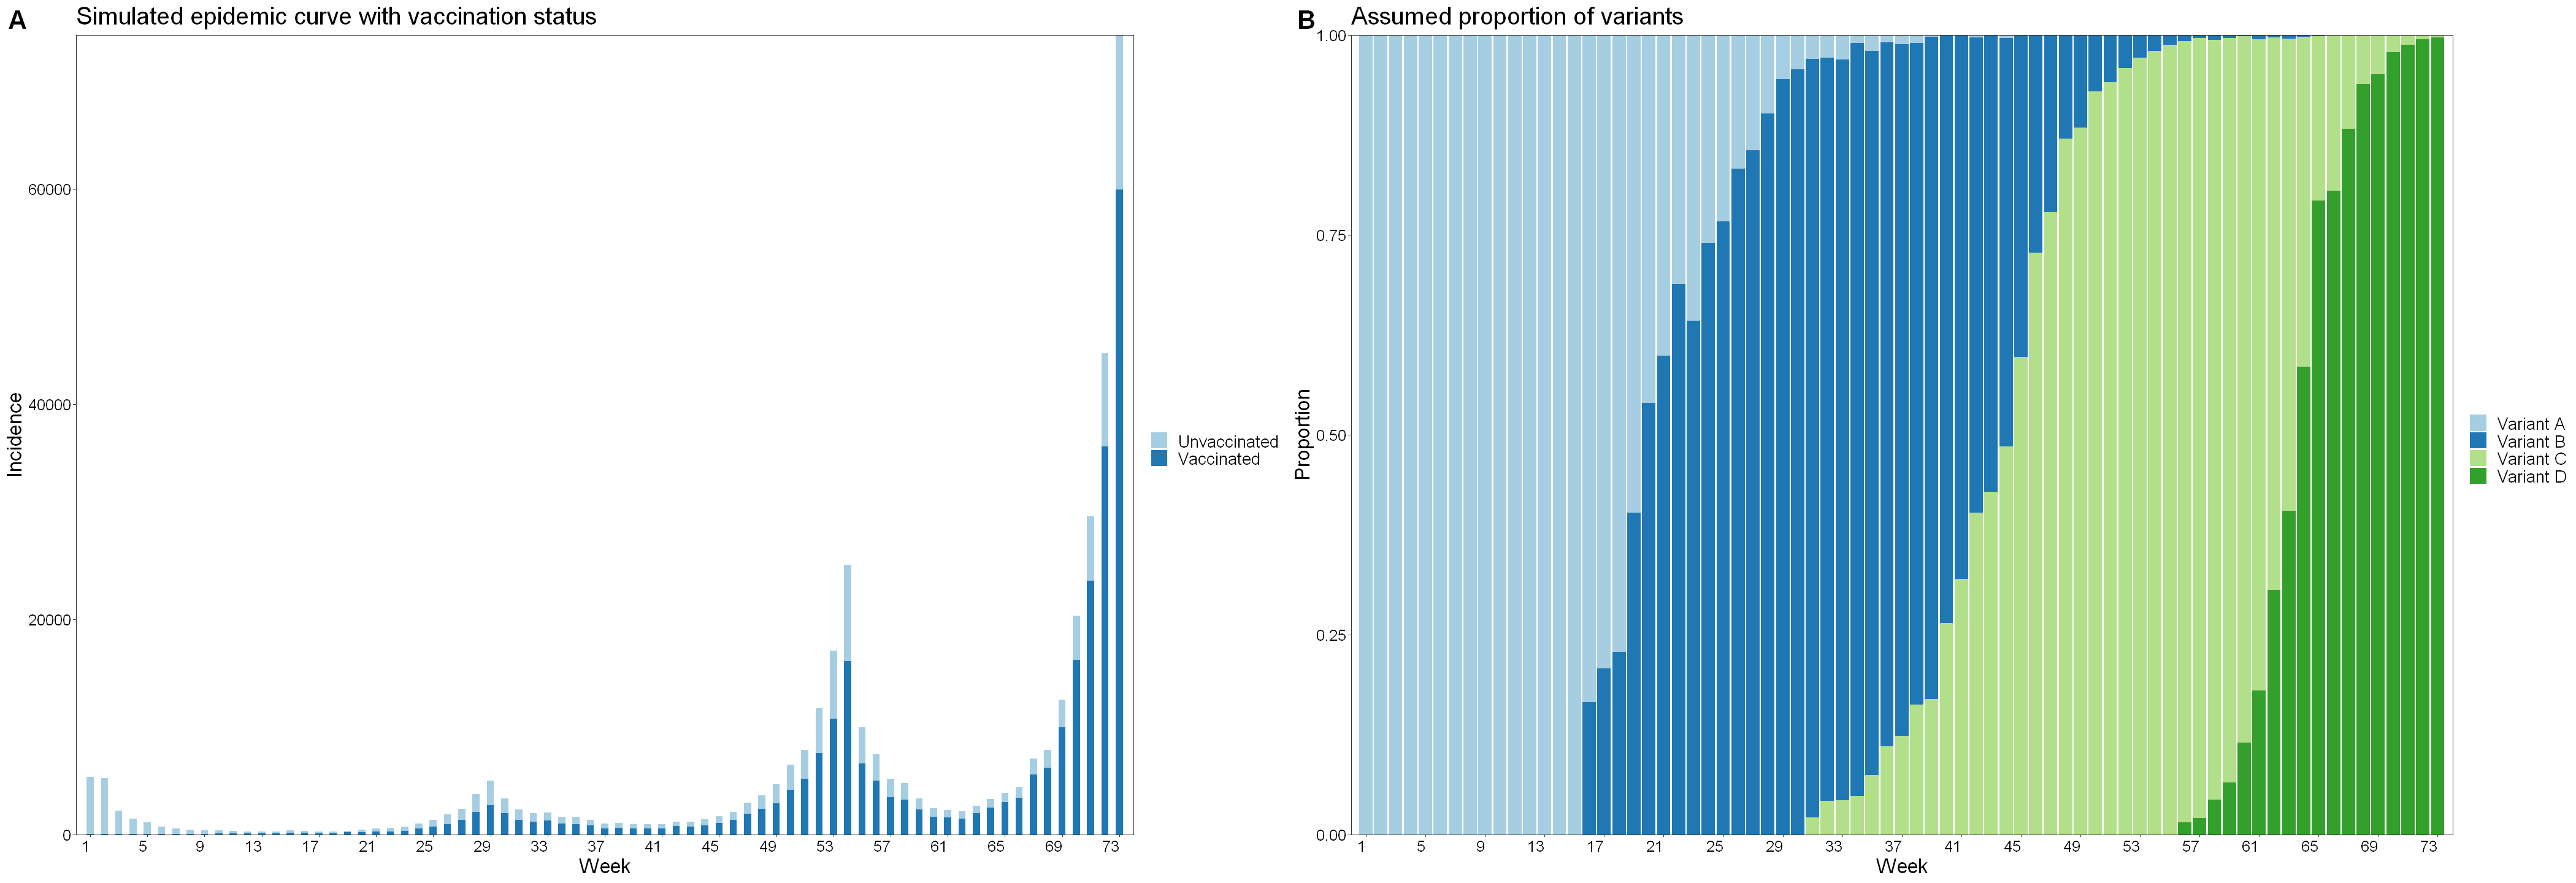

In [27]:
options(repr.plot.width=35,repr.plot.height=12)
ggarrange(case_simulation, voc_plot, nrow=1,ncol=2,font.label=list(size=25),labels=c("A","B"),legend="right")
ggsave(file = "output/simulation_data.pdf", width = 35, height = 12)

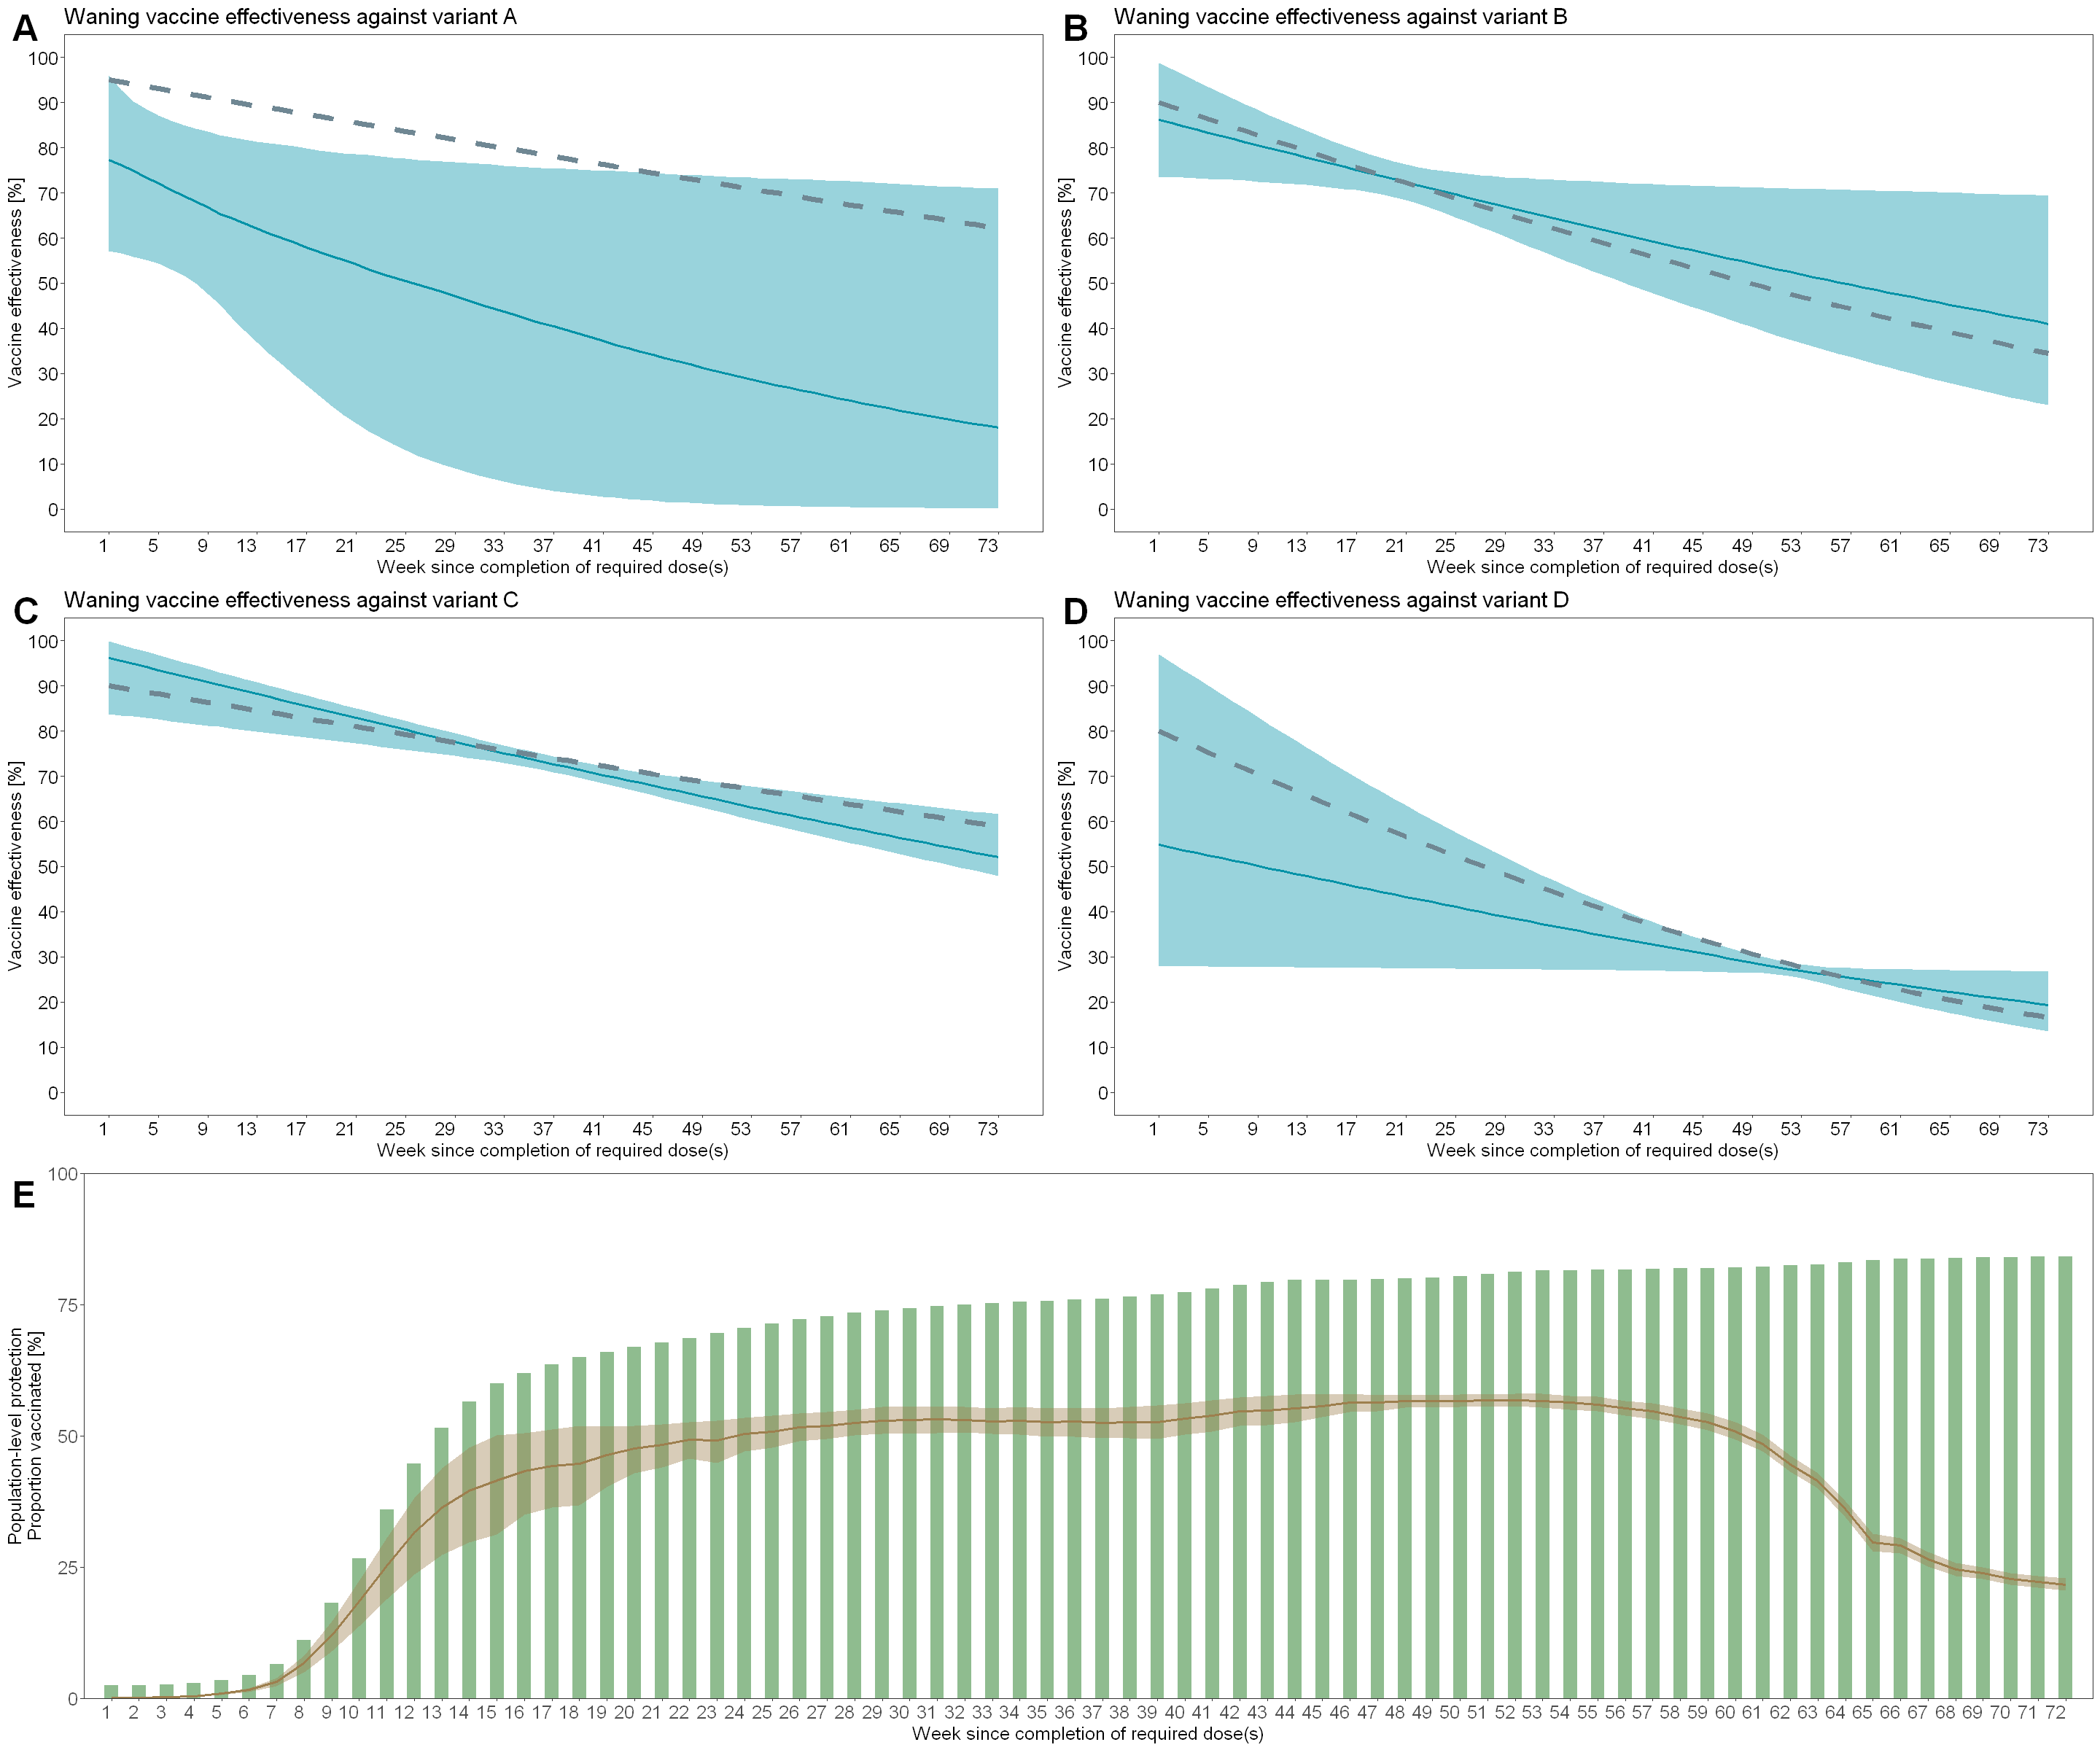

In [41]:
options(repr.plot.width=24,repr.plot.height=20)
direct_effect1 <- ggarrange(delta_plot, omicron_plot, nrow=1,ncol=2,labels=c("C","D"),font.label=list(size=30),common.legend=TRUE,legend="right")
direct_effect2 <- ggarrange(others_plot,alpha_plot, nrow=1,ncol=2,labels=c("A","B"),font.label=list(size=30),common.legend=TRUE,legend="right")
ggarrange(direct_effect2, direct_effect1, overall_plot, nrow=3,ncol=1,font.label=list(size=30),labels=c("","","E"),legend="right")
ggsave(file = "output/VE_waning_simulation1_param.png", width = 24, height = 20)

In [9]:
voc_plot <- voc %>% ggplot() +
  geom_bar(aes(x=week,y=Proportion, fill=Variant_type), stat = "identity") +
  scale_x_continuous(breaks = seq(1, 73, 4), limits=c(0, 74), expand = c(0,0)) +
  scale_y_continuous(expand = c(0,0))+
  labs(x="Week", y="Proportion") +
  ggtitle("Assumed proportion of variants") +
  theme_bw() + theme(axis.text.x = element_text(size=15, angle = 0, hjust = 1),axis.text.y = element_text(size=15)) + scale_fill_brewer(palette = "Paired") + 
    theme(text = element_text(size=20, family="sans",color="black"),
          axis.text = element_text(size=10, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + guides(fill=guide_legend(""))

case_simulation <- df %>% ggplot() +
  geom_bar(aes(x=Week,y=Case, fill=Type), stat = "identity", width=0.5) +
  scale_x_continuous(breaks = seq(1, 73, 4), limits=c(0, 74), expand = c(0,0)) +
  scale_y_continuous(expand = c(0,0))+
  labs(x="Week", y="Incidence") +
  ggtitle("Simulated epidemic curve by vaccination status") + scale_fill_brewer(palette = "Paired") +
  theme_bw() + theme(axis.text.x = element_text(size=15, angle = 0, hjust = 1),axis.text.y = element_text(size=15)) +
    theme(text = element_text(size=20, family="sans",color="black"),
          axis.text = element_text(size=10, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + guides(fill=guide_legend(""))

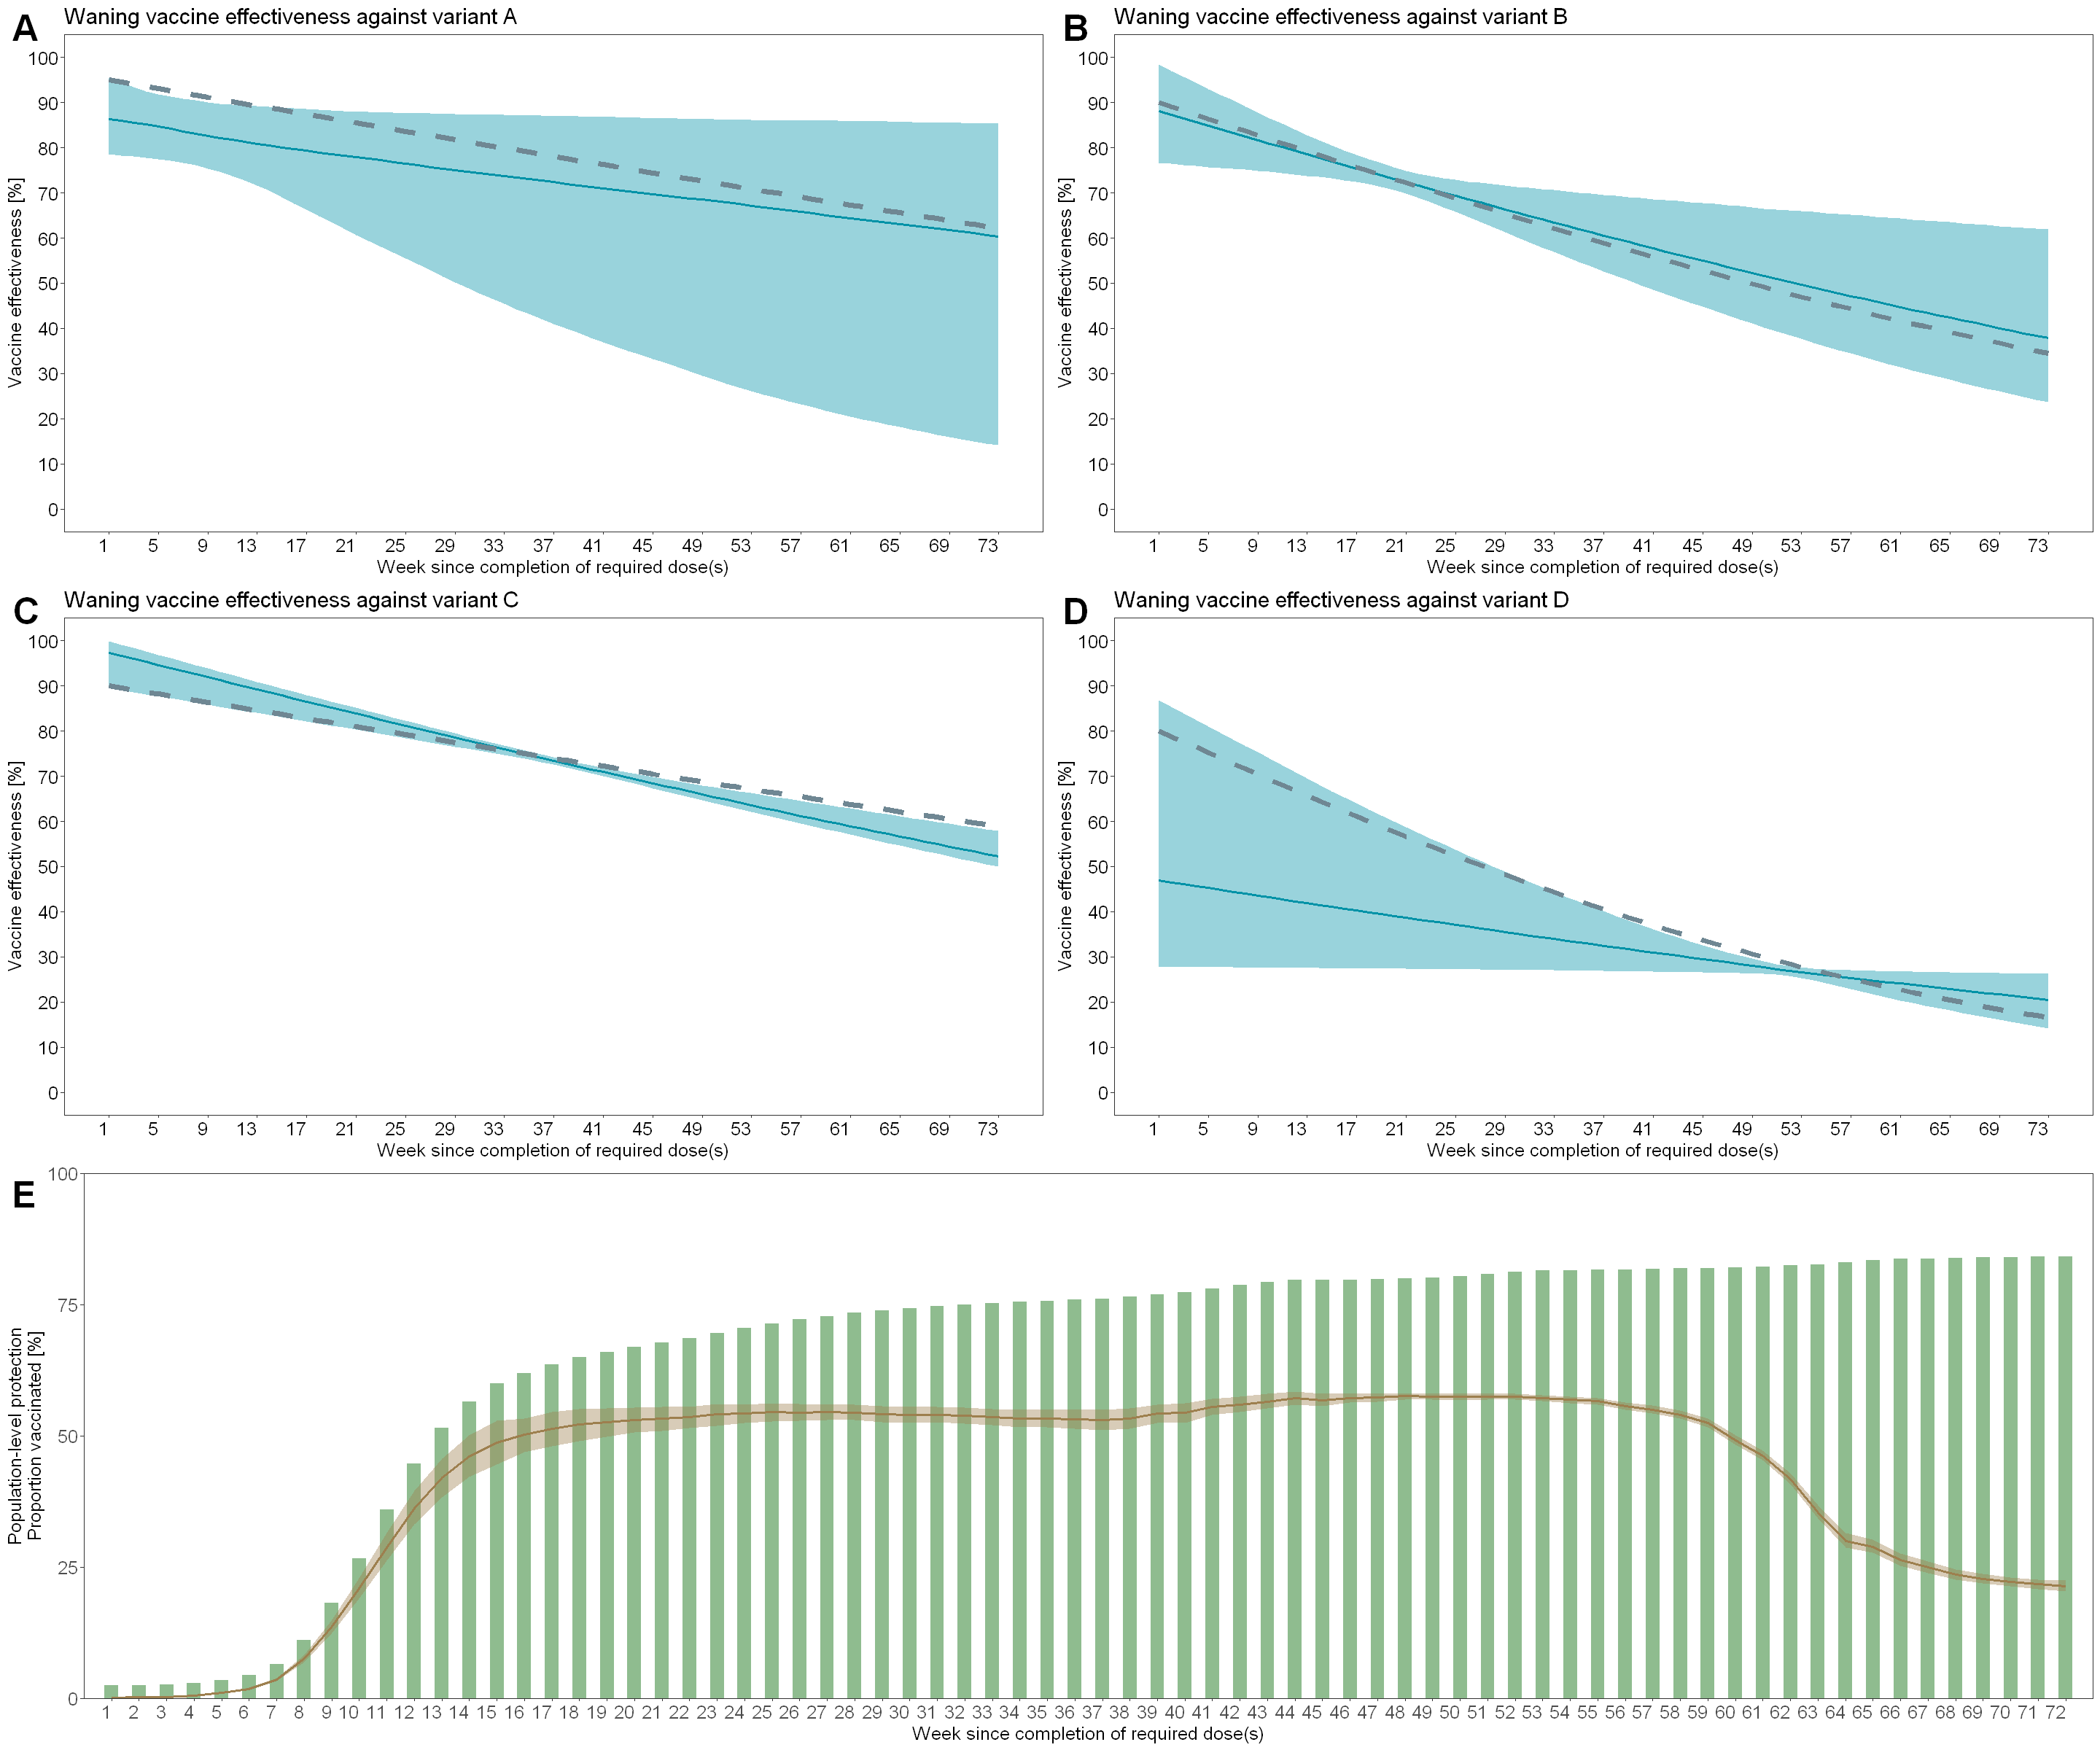

In [32]:
options(repr.plot.width=24,repr.plot.height=20)
direct_effect1 <- ggarrange(delta_plot, omicron_plot, nrow=1,ncol=2,labels=c("C","D"),font.label=list(size=30),common.legend=TRUE,legend="right")
direct_effect2 <- ggarrange(others_plot,alpha_plot, nrow=1,ncol=2,labels=c("A","B"),font.label=list(size=30),common.legend=TRUE,legend="right")
ggarrange(direct_effect2, direct_effect1, overall_plot, nrow=3,ncol=1,font.label=list(size=30),labels=c("","","E"),legend="right")

ggsave(file = "output/VE_waning_simulation1_param.pdf", width = 24, height = 20)

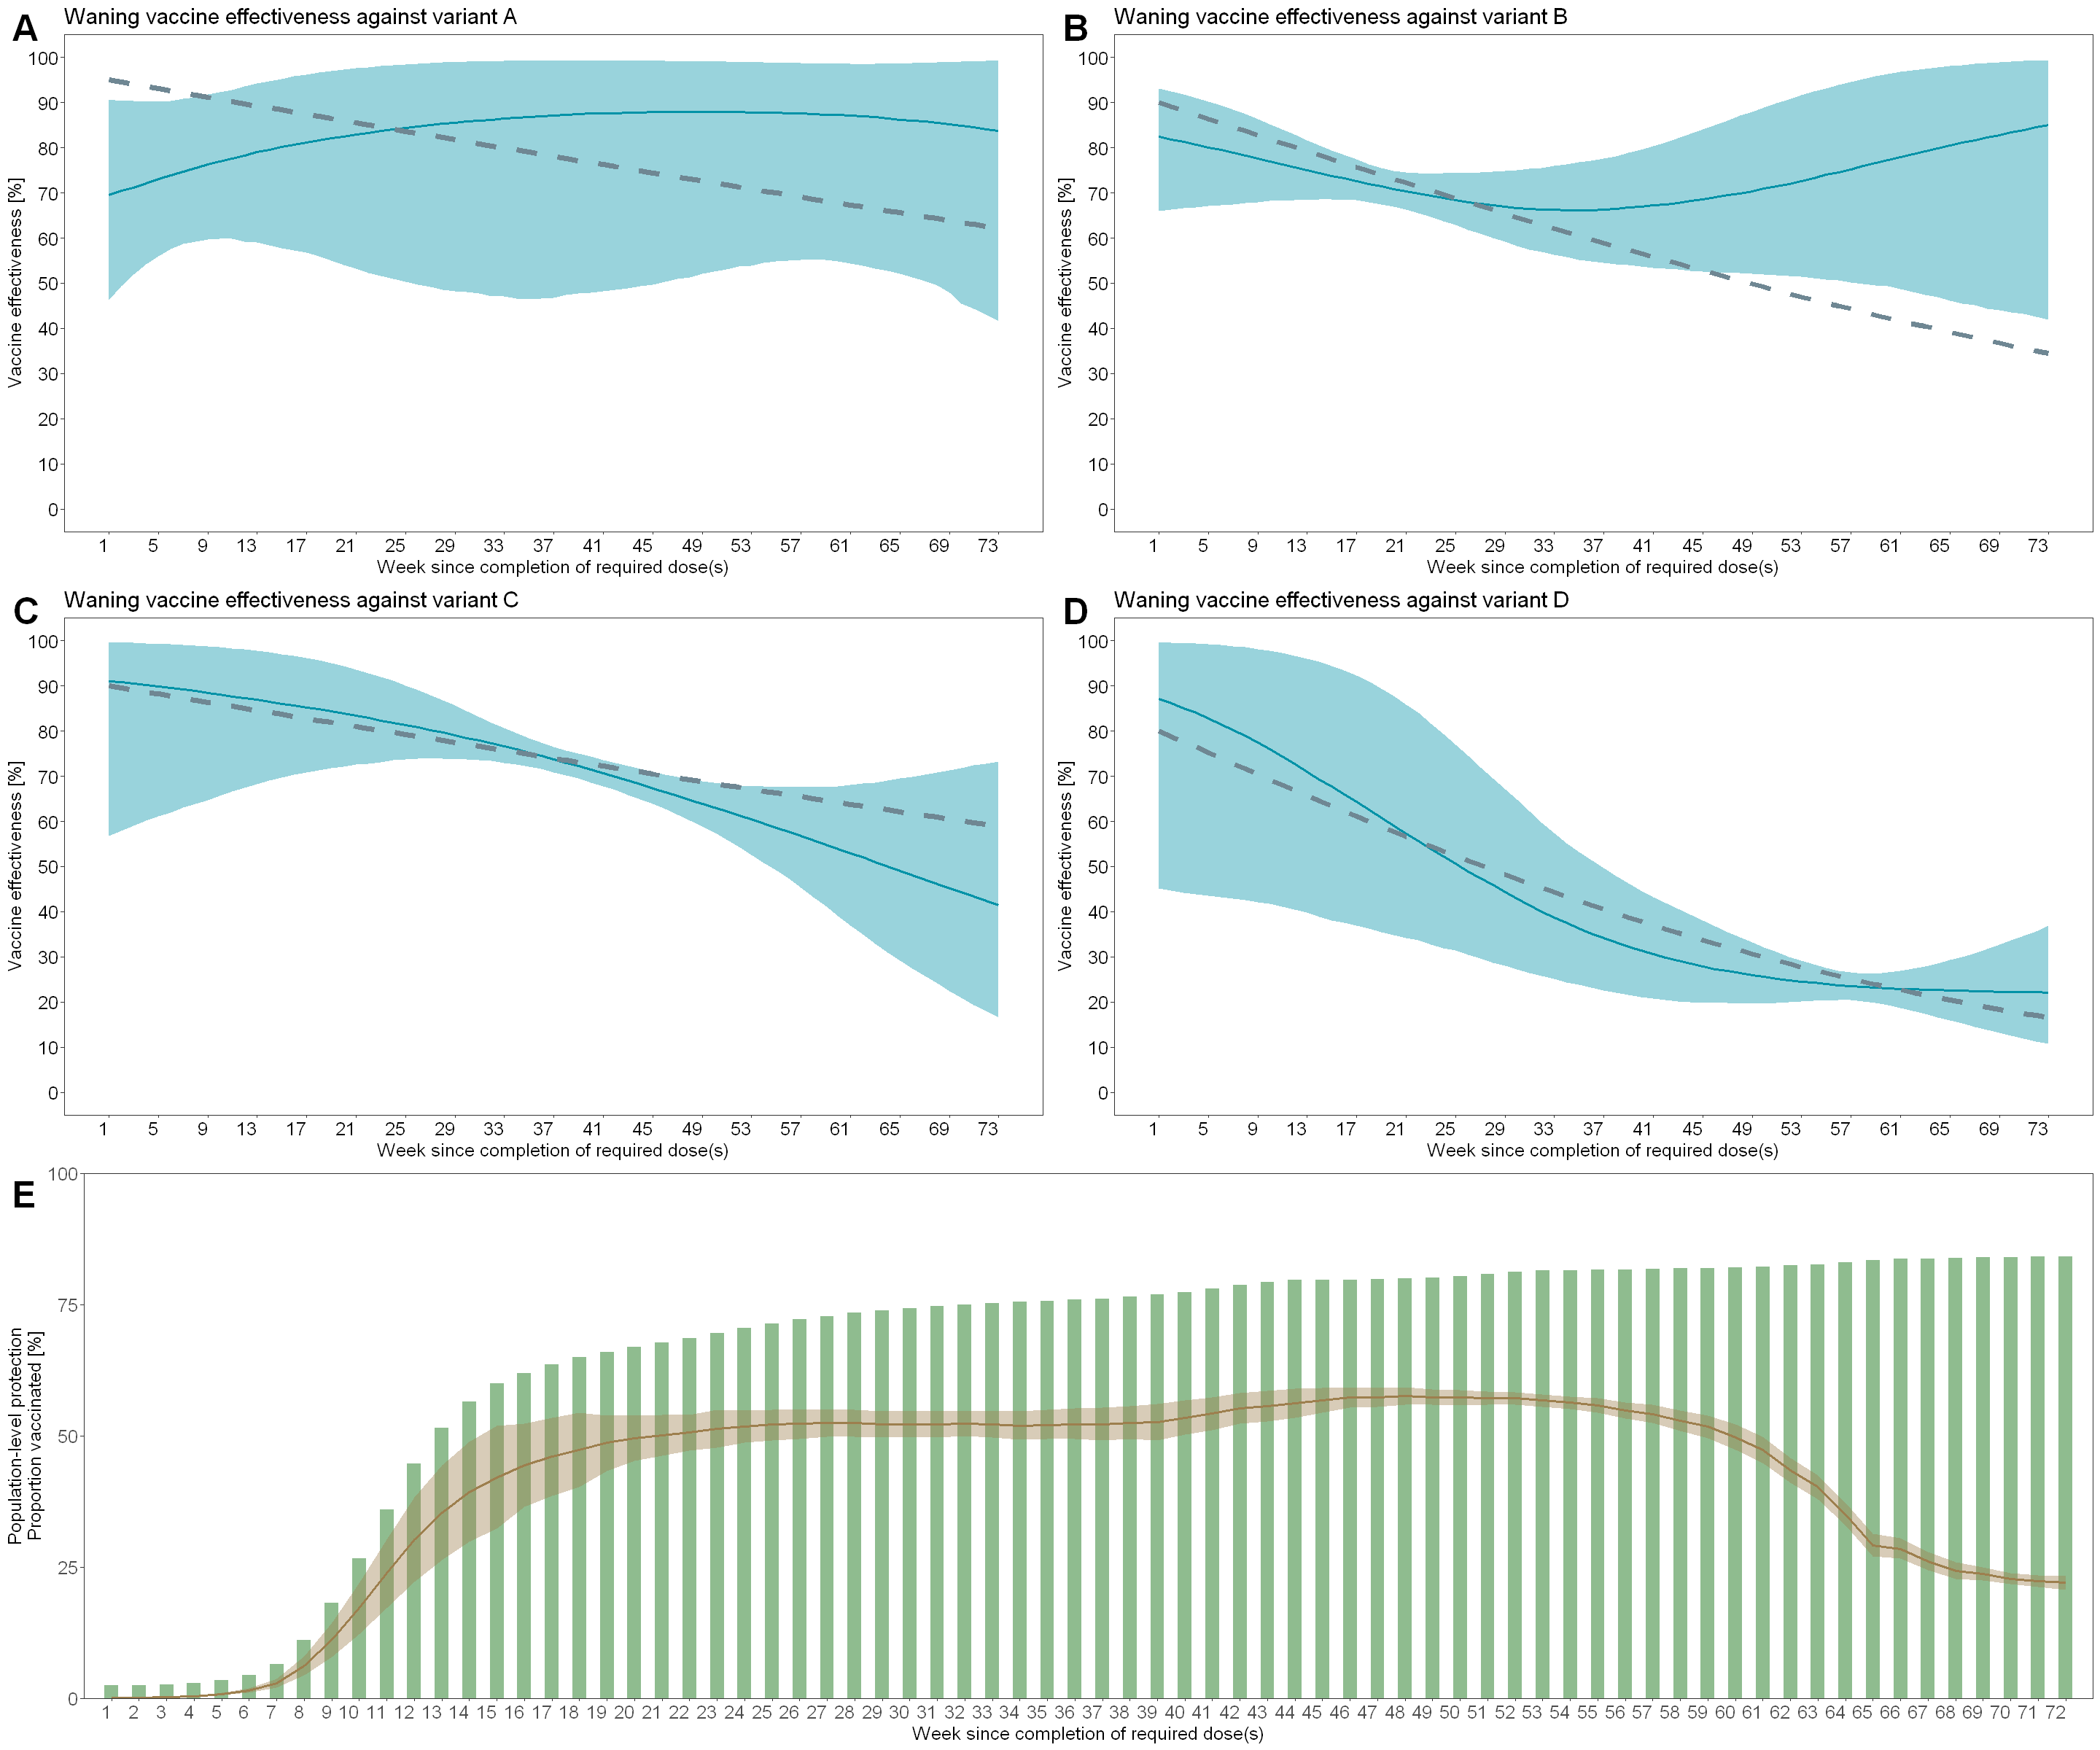

In [18]:
options(repr.plot.width=24,repr.plot.height=20)
direct_effect1 <- ggarrange(delta_plot, omicron_plot, nrow=1,ncol=2,labels=c("C","D"),font.label=list(size=30),common.legend=TRUE,legend="right")
direct_effect2 <- ggarrange(others_plot,alpha_plot, nrow=1,ncol=2,labels=c("A","B"),font.label=list(size=30),common.legend=TRUE,legend="right")
ggarrange(direct_effect2, direct_effect1, overall_plot, nrow=3,ncol=1,font.label=list(size=30),labels=c("","","E"))

ggsave(file = "output/VE_waning_simulation1_spline.pdf", width = 24, height = 20)